<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from backtesting import Strategy, Backtest
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG

class SmaCross(Strategy):
    
    up_fast = 10
    up_slow = 20
    
    def init(self):
        
        price = self.data.Close # to be fed to indicator
        self.up_fast = self.I(SMA, price, self.up_fast) # callable, callable args
        self.up_slow = self.I(SMA, price, self.up_slow)
        
    def next(self):
        
        if crossover(self.up_fast, self.up_slow):
            self.buy()
            
        if crossover(self.up_slow, self.up_fast):
            self.sell()

bt = Backtest(GOOG, SmaCross, cash=10000,commission=.002, exclusive_orders=True) 
stats = bt.optimize(up_fast=range(5, 30, 5),
                    up_slow=range(10, 70, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.up_fast < param.up_slow)
eq = stats._equity_curve["Equity"]
ret = eq[-1]/eq[0]
dur = stats["Duration"].days
ret_ann = ret**(252/dur) -1
print(stats)

/home/sergey/anaconda3/lib/python3.7/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                     99.0689
Equity Final [$]                       103949
Equity Peak [$]                        108328
Return [%]                            939.494
Buy & Hold Return [%]                 703.458
Return (Ann.) [%]                     31.6109
Volatility (Ann.) [%]                 44.7398
Sharpe Ratio                          0.70655
Sortino Ratio                         1.49096
Calmar Ratio                         0.718505
Max. Drawdown [%]                    -43.9954
Avg. Drawdown [%]                    -6.13885
Max. Drawdown Duration      690 days 00:00:00
Avg. Drawdown Duration       43 days 00:00:00
# Trades                                  153
Win Rate [%]                           51.634
Best Trade [%]                        61.5629
Worst Trade [%]                      -19.7783
Avg. Trade [%]                    

In [50]:
# Return (Ann.) [%]
eq = stats._equity_curve["Equity"].sort_index()
ret = eq[-1]/eq[0]
dur = stats["Duration"].days
dur = bt._data.shape[0]
ret_ann = ret**(252/dur) -1
print(ret_ann*100, stats["Return (Ann.) [%]"])

31.610935989553134 31.61093598955005


In [376]:
eq[-1]/eq[0]-1

9.394942611999982

In [27]:
# Volatility (Ann.) [%] 
s = stats._equity_curve.Equity.pct_change().dropna(0).std()*np.sqrt(252)
print(s*100, stats["Volatility (Ann.) [%]"])

33.10864212390824 44.73981572651169


In [57]:
for year in np.unique(eq.index.year):
    eq_ = eq[str(year)].sort_index(ascending=True)
    ret_= np.prod(eq_.pct_change().fillna(0) + 1)
    assert eq_[0]*ret_, eq[-1]

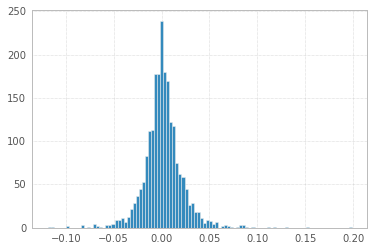

In [369]:
ret = eq.pct_change().fillna(0)
plt.hist(ret,100);

In [208]:
from scipy.stats import normaltest, probplot, boxcox, boxcox_normmax, shapiro
normaltest(ret), shapiro(ret)

(NormaltestResult(statistic=527.0072202266264, pvalue=3.646163726378504e-115),
 ShapiroResult(statistic=0.9102035760879517, pvalue=7.510560341769917e-34))

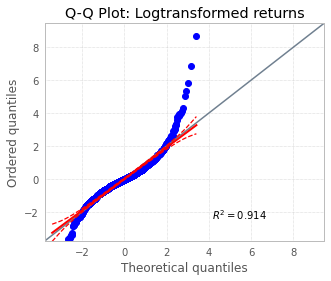

In [373]:
qqplot(np.log(1+ret))
plt.title("Q-Q Plot: Logtransformed returns");

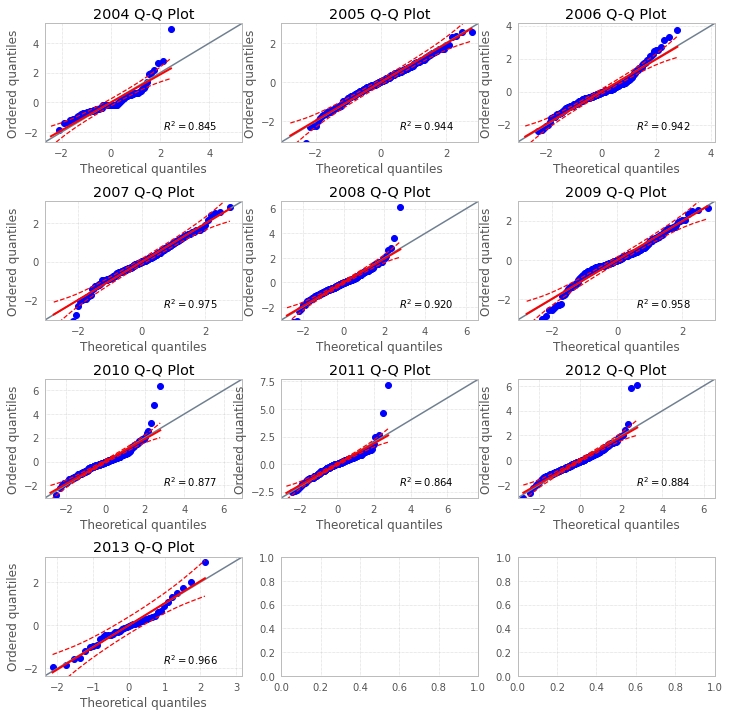

In [211]:
years = np.unique(eq.index.year)
ncols = int(np.sqrt(len(years)))
nrows = len(years)//n_cols + 1
fig,axes = plt.subplots(nrows=nrows, ncols=ncols,)
fig.set_size_inches(12,12)
for ax,year in zip(axes.ravel(), years):
    qqplot(ret[str(year)], ax=ax, figsize=(5,5))
    ax.set_title(f"{year} Q-Q Plot")

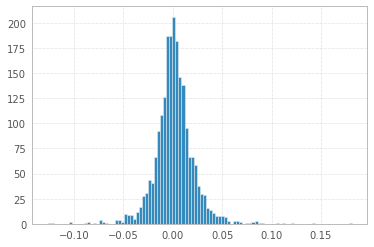

In [203]:
log_ret = np.log(ret+1)
plt.hist(log_ret,100);

In [212]:
normaltest(log_ret), shapiro(log_ret)

(NormaltestResult(statistic=397.7278228089233, pvalue=4.310231806242585e-87),
 ShapiroResult(statistic=0.9163585305213928, pvalue=6.673958808237788e-33))

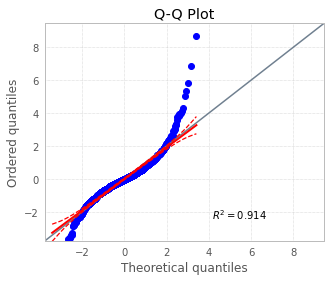

In [214]:
qqplot(log_ret);

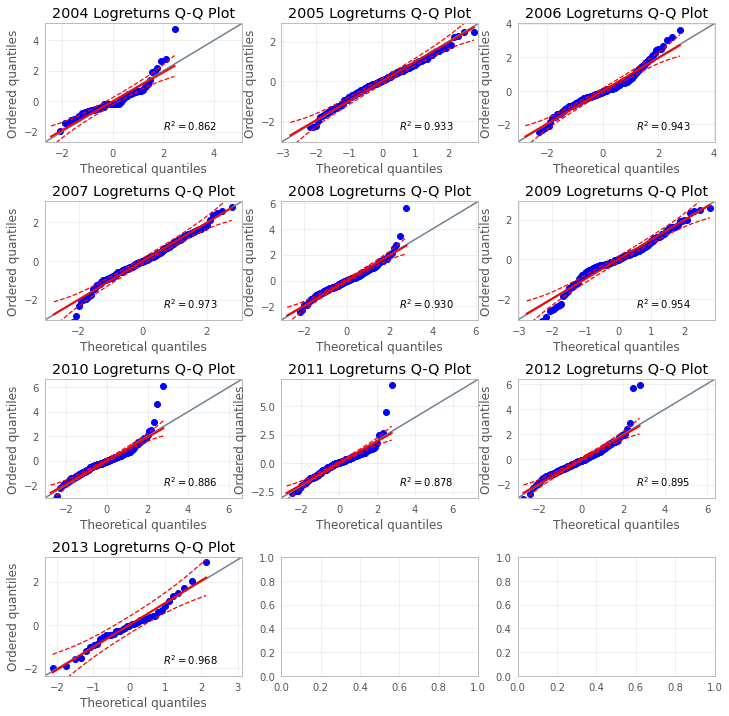

In [378]:
log_ret = np.log(ret+1)
fig,axes = plt.subplots(nrows=nrows, ncols=ncols,)
fig.set_size_inches(12,12)
for ax,year in zip(axes.ravel(), years):
    qqplot(log_ret[str(year)], ax=ax, figsize=(5,5))
    ax.set_title(f"{year} Logreturns Q-Q Plot");

In [351]:
def lognstat(mu, sigma):
    """Calculate the mean of and variance of the lognormal distribution given
    the mean (`mu`) and standard deviation (`sigma`), of the associated normal 
    distribution."""
    m = np.exp(mu + sigma**2 / 2.0)
    v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
    return m, np.sqrt(v)


In [362]:
lognstat(np.log(1+ret2010).mean()*252, np.log(1+ret2010).std()*np.sqrt(252))

(1.2013646766275827, 0.33456885055562186)

In [364]:
for year in years:
    eq_ = eq[str(year)].sort_index(ascending=True)
    ret_= eq_.pct_change().fillna(0)
    mu_ret, std_ret = lognstat(np.log(1+ret_).mean()*252,np.log(1+ret_).std(ddof=1)*np.sqrt(252))
    print("Year:",
          year,
          "Relized return:",
          round((eq_[-1]/eq_[0]-1)*100,2),
          "Annualized return:",
          round((mu_ret-1)*100,2))

Year: 2004 Relized return: 68.18 Annualized return: 349.32
Year: 2005 Relized return: 54.01 Annualized return: 63.16
Year: 2006 Relized return: 45.0 Annualized return: 52.86
Year: 2007 Relized return: 15.65 Annualized return: 19.35
Year: 2008 Relized return: 85.34 Annualized return: 109.92
Year: 2009 Relized return: -1.95 Annualized return: 2.38
Year: 2010 Relized return: 15.73 Annualized return: 20.14
Year: 2011 Relized return: -21.51 Annualized return: -18.23
Year: 2012 Relized return: 23.99 Annualized return: 27.26
Year: 2013 Relized return: 3.11 Annualized return: 22.9


In [262]:
def annualized_return(ret):
    mean_day = ret.mean()
    return (1+mean_day)**252 -1

In [267]:
for year in years:
    eq_ = eq[str(year)].sort_index(ascending=True)
    ret_= eq_.pct_change().fillna(0)
    print("Year:",
          year,
          "Relized return:",
          round((eq_[-1]/eq_[0]-1)*100,2),
          "Annualized return:",
          round(annualized_return(ret_)*100,2))

Year: 2004 Relized return: 68.18 Annualized return: 349.44
Year: 2005 Relized return: 54.01 Annualized return: 63.04
Year: 2006 Relized return: 45.0 Annualized return: 52.84
Year: 2007 Relized return: 15.65 Annualized return: 19.33
Year: 2008 Relized return: 85.34 Annualized return: 109.95
Year: 2009 Relized return: -1.95 Annualized return: 2.35
Year: 2010 Relized return: 15.73 Annualized return: 20.15
Year: 2011 Relized return: -21.51 Annualized return: -18.22
Year: 2012 Relized return: 23.99 Annualized return: 27.26
Year: 2013 Relized return: 3.11 Annualized return: 22.85


In [ ]:
def annualized_volatility(ret):
    sd = ret.std(ddof=1)
    sa = 
    return 

In [9]:
import notebook
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension('ipy2wp/ipy2wp')

AttributeError: 'EnableNBExtensionApp' object has no attribute 'enable_nbextension'

> <ipython-input-9-58093baf16f9>(3)<module>()
      1 import notebook
      2 E = notebook.nbextensions.EnableNBExtensionApp()
----> 3 E.enable_nbextension('ipy2wp/ipy2wp')

ipdb> q


In [65]:
def lognstat(mu, sigma):
    """Calculate the mean of and variance of the lognormal distribution given
    the mean (`mu`) and standard deviation (`sigma`), of the associated normal 
    distribution."""
    m = np.exp(mu + sigma**2 / 2.0)
    v = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
    return m, v

In [69]:
log_day_returns = np.log(day_returns+1)
mu = log_day_returns.mean()*252
sigma = log_day_returns.std()*np.sqrt(252)
m,v = lognstat(mu,sigma)
(m-1)*100, (np.sqrt(v))*100

(38.919616652960244, 46.935262560485356)

In [7]:
# Trade Expectancy [%]
exp_ret = stats._trades["ReturnPct"].mean()
print(exp_ret*100, stats["Expectancy [%]"])

1.9798796110462602 1.979879611046262


In [8]:
# Trade expectancy per day
trade_duration = round(dur*stats["Exposure Time [%]"]/100)
exp_ret_per_day = ret**(1/trade_duration) -1
print(exp_ret_per_day)

0.0007587325902018716


In [9]:
# Trade expectancy annualized
exp_ret_ann = (1+exp_ret_per_day)**252 -1
print(exp_ret_ann)

0.2106145392193397


In [9]:
def geometric_mean(returns):
    returns = returns.fillna(0) + 1
    return (0 if np.any(returns <= 0) else
            np.exp(np.log(returns).sum() / (len(returns) or np.nan)) - 1)

day_returns = stats._equity_curve["Equity"].resample('D').last().dropna(0).pct_change()

(1+geometric_mean(day_returns))**252

1.3161093598955005